# Elevator Position Estimation Using 1D Kalman Filter

By Fabiano Junior Maia Manschein

For the Robotic Perception class of Toyohashi University of Tecnology

Imaging and Light in Extended Reality (IMLEX) Master Program, 2023

## Problem definition

Imagine an elevator moving within a building, and you have a sensor that measures the elevator's position within the shaft. However, due to sensor inaccuracies or environmental factors, the sensor measurements contain noise and uncertainties.

## Goal

The objective is to implement a 1D Kalman Filter to estimate the elevator's position accurately despite the noisy sensor measurements.

## Steps to implement

1. Data Generation:
- Simulate or obtain a dataset representing the elevator's true position along the road. This dataset will serve as the ground truth.
- Introduce artificial noise or uncertainty into the dataset to mimic the sensor measurements.

2. Kalman Filter Implementation:
- Utilize the FilterPy Python library.
- Set up the initial state of the Kalman Filter. This includes defining the initial estimate of the elevator's position and velocity (if available), and initializing the covariance matrix.
- Define parameters for process noise (representing the uncertainty in the elevator's movement) and measurement noise (representing sensor inaccuracies).
- Iterate through the simulated sensor measurements, applying the Kalman Filter to estimate the elevator's position at each measurement instance.
- Store the estimated positions obtained from the Kalman Filter.

3. Animation:
- Animate an elevator moving up and down, with the Kalman Filter estimating its position.

# Data Generation

The goal here is simple. Write a simple script to simulate an elevator moving along a shaft, with noisy sensors feeding-off position data. We'll have the ground truth data separated from the noisy data.

In this case, we assume a constant velocity model.

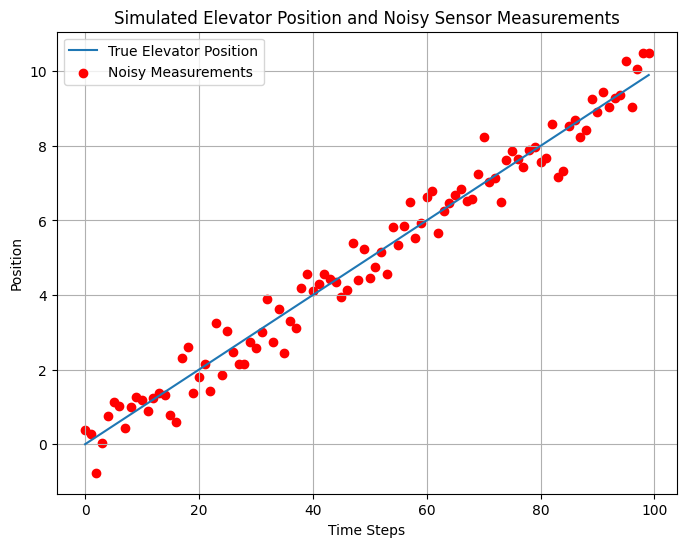

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def generate_elevator_data(num_steps, initial_position=0, velocity=0.1, measurement_noise_std=0.5):
    # Simulate true elevator positions over time
    true_positions = [initial_position + velocity * t for t in range(num_steps)]

    # Add noise to simulate sensor measurements
    noisy_measurements = [pos + np.random.normal(scale=measurement_noise_std) for pos in true_positions]

    return true_positions, noisy_measurements

# Generate data for 100 time steps with default parameters
num_steps = 100
true_positions, noisy_measurements = generate_elevator_data(num_steps)

# Plot true elevator positions and noisy sensor measurements
plt.figure(figsize=(8, 6))
plt.plot(range(num_steps), true_positions, label='True Elevator Position')
plt.scatter(range(num_steps), noisy_measurements, color='red', label='Noisy Measurements')
plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.title('Simulated Elevator Position and Noisy Sensor Measurements')
plt.legend()
plt.grid(True)
plt.show()


# Kalman Filter Implementation

For each measurement in `noisy_measurements`, the Kalman Filter performs the prediction step (`kf.predict()`) to estimate the next state and the update step (`kf.update(measurement)`) to correct the prediction based on the noisy measurement.

The filtered estimates of the elevator's position are stored in the `filtered_positions` list, and the final visualization plots the true elevator positions, noisy sensor measurements, and the filtered estimates obtained from the Kalman Filter over time.

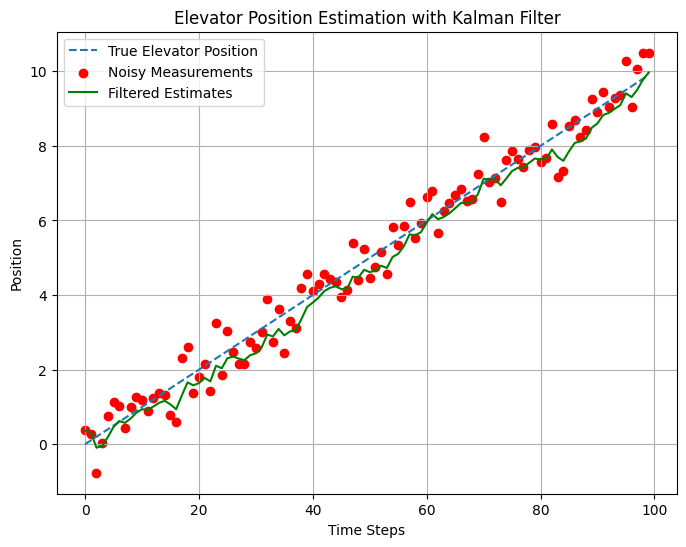

In [68]:
from filterpy.kalman import KalmanFilter

def apply_kf(noisy_measurements):
    # Initialize Kalman Filter
    kf = KalmanFilter(dim_x=1, dim_z=1)  # 1D Kalman Filter
    kf.x = np.array([0.0])  # Initial state estimate
    kf.F = np.array([[1.0]])  # State transition matrix (constant velocity model)
    kf.H = np.array([[1.0]])  # Measurement matrix
    kf.P *= 10.0  # Initial state covariance matrix
    kf.R *= 0.1  # Measurement noise covariance matrix
    kf.Q = np.eye(1) * 0.01  # Process noise covariance matrix

    # Perform Kalman filtering
    kf_estimates = []
    for measurement in noisy_measurements:
        kf.predict()  # Prediction step
        kf.update(measurement)  # Correction step
        kf_estimates.append(kf.x[0])
    return kf_estimates

kf_estimates = apply_kf(noisy_measurements)

# Plot true elevator positions, noisy measurements, and filtered estimates
plt.figure(figsize=(8, 6))
plt.plot(range(num_steps), true_positions, label='True Elevator Position', linestyle='--')
plt.scatter(range(num_steps), noisy_measurements, color='red', label='Noisy Measurements')
plt.plot(range(num_steps), kf_estimates, color='green', label='Filtered Estimates')
plt.xlabel('Time Steps')
plt.ylabel('Position')
plt.title('Elevator Position Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()


About the KF parameters:
1. **`dim_x=1` and `dim_z=1`:**
   - `dim_x=1` specifies that our state space is one-dimensional (representing the elevator's position).
   - `dim_z=1` indicates that our measurement space is also one-dimensional (one sensor measuring the elevator's position).

2. **Initial State (`kf.x`):**
   - `kf.x = np.array([0.0])`: We initialize the initial estimated state of the elevator's position as 0.0. This represents our initial belief about where the elevator is when starting the filtering process.

3. **State Transition Matrix (`kf.F`):**
   - `kf.F = np.array([[1.0]])`: Given a constant velocity model (1D), the state transition matrix `F` denotes how the state evolves over time. Here, it's a simple representation where the elevator's position evolves linearly with time (no change in velocity).

4. **Measurement Matrix (`kf.H`):**
   - `kf.H = np.array([[1.0]])`: The measurement matrix `H` relates the true state to the observed measurements. In this case, the sensor directly measures the elevator's position.

5. **Initial Covariance Matrix (`kf.P`):**
   - `kf.P *= 10.0`: The initial state covariance matrix represents our uncertainty about the initial state estimate. Setting it to a higher value (e.g., 10.0) implies higher uncertainty in our initial estimate.

6. **Measurement Noise Covariance (`kf.R`):**
   - `kf.R *= 0.1`: This matrix represents the covariance of the noise in the sensor measurements. A lower value (e.g., 0.1) signifies less uncertainty in the sensor measurements.

7. **Process Noise Covariance (`kf.Q`):**
   - `kf.Q = np.eye(1) * 0.01`: The process noise covariance matrix represents the uncertainty in the system's dynamics. Here, a small value (e.g., 0.01) suggests low uncertainty in the elevator's movement dynamics.

These parameter choices aim to balance the initial uncertainty, process noise, and measurement noise in a simple 1D Kalman Filter setup for estimating the elevator's position based on noisy sensor measurements. Adjustments may be necessary based on the specific characteristics of the elevator system or sensor behavior. For now, we'll keep it as it is.

# Animation

In [77]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import floor


def simulate_elevator_movement(total_floors, num_steps_per_floor):
    going_up = True  # 1 for moving up, -1 for moving down
    arrow = "↑"

    # Generate elevator data
    num_steps = num_steps_per_floor * total_floors
    true_positions, noisy_measurements = generate_elevator_data(num_steps, measurement_noise_std=0.2)

    # Apply Kalman Filter
    kf_estimates = apply_kf(noisy_measurements)

    fig, ax = plt.subplots(figsize=(4, 6))

    i = 0
    while i < num_steps:
        ax.clear()

        ax.set_xlim(-1, 1)
        ax.set_ylim(0, total_floors + 1)
        ax.set_title(f"Elevator at floor [{floor(true_positions[i])} {arrow}]")

        # Elevator shaft
        ax.plot([0, 0], [0, total_floors + 1], color='black')

        # True elevator position
        elevator_pos = true_positions[i]  # Constrain elevator within floors range
        ax.fill(
            [-0.2, 0.2, 0.2, -0.2], 
            [elevator_pos, elevator_pos, elevator_pos + 1, elevator_pos + 1], 
            color='blue', 
            alpha=0.3,
        )  # This draws the elevator box
        ax.scatter(
            0, 
            true_positions[i], 
            color='blue', 
            label='GT',
            marker='s'
        )  # This draws a dot at the ground truth point

        # Noisy measurements
        ax.scatter(0, 
                   noisy_measurements[i], 
                   color='green', 
                   label='NM', 
                   marker='x'
        )

        # Kalman filter estimates
        # if i < len(kf_estimates):
        kf_pos = kf_estimates[i]  
        ax.fill(
            [-0.2, 0.2, 0.2, -0.2], 
            [kf_pos, kf_pos, kf_pos + 1, kf_pos + 1], 
            color='red', 
            alpha=0.3, 
        )
        ax.scatter(
            0, 
            kf_estimates[i], 
            color='red', 
            label='KF',
            marker='^'
        )  # This draws a dot at the ground truth point

        # Elevator goes down after arriving at the top
        if (going_up and i == num_steps-1) or (not going_up and i == 0):
            going_up = not going_up
            arrow = "↑" if going_up else "↓"
            plt.pause(3)

        # Increment or decrement counter depending on direction
        i = i+1 if going_up else i-1

        ax.legend()
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)

    plt.close()

# Run the elevator simulation
simulate_elevator_movement(10, 10)


KeyboardInterrupt: 